In [ ]:
# Gerekli kütüphaneleri indir
!pip install kaggle gradio

import os
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# Kaggle API dosyasının yerini göster
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
print("Kurulumlar tamamlandı.")

In [15]:
# Veri seti daha önce indirilmiş mi kontrol et
if not os.path.exists('/content/chest-xray-pneumonia.zip'):
    print("Veri seti Kaggle'dan indiriliyor...")
    !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
else:
    print("Zip dosyası zaten mevcut.")

# Zip dosyasını çıkar
if not os.path.exists('/content/chest_xray'):
    print("Zip dosyası açılıyor (Biraz sürebilir)...")
    with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
        zip_ref.extractall('/content')
    print("Zip açma işlemi tamamlandı!")
else:
    print("Klasör zaten açık, devam edebilirsin.")

Zip dosyası zaten mevcut.
Klasör zaten açık, devam edebilirsin.


In [16]:
# Klasör yolları (Dataset zip yapısına göre)
train_dir = '/content/chest_xray/train'
test_dir = '/content/chest_xray/test'
val_dir = '/content/chest_xray/val'

# Eğitim verileri için çoğaltma (Augmentation) ayarları
# Bu, modelin ezberlemesini önler
train_datagen = ImageDataGenerator(
    rescale=1./255,       # Pikselleri 0-1 arasına getir
    rotation_range=20,    # Resmi hafifçe döndür
    zoom_range=0.2,       # Hafifçe yakınlaştır
    horizontal_flip=True  # Yatay çevir
)

# Test verileri için sadece ölçekleme (Rescale) yapılır
test_datagen = ImageDataGenerator(rescale=1./255)

# Verileri klasörden okuyucuya yükle
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224), # VGG16 standardı
    batch_size=32,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [17]:
# VGG16 Modelini indir (En üst katmanı hariç)
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

# VGG16'nın kendi ağırlıklarını dondur (Eğitilmesin)
conv_base.trainable = False

# Kendi sınıflandırma katmanlarımızı ekleyelim
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) # Ezberlemeyi engelle
model.add(layers.Dense(1, activation='sigmoid')) # Sonuç: 0 veya 1

# Modeli derle
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

print("Model mimarisi hazır.")
model.summary()

Model mimarisi hazır.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
print("Eğitim başlıyor... Lütfen bekleyin.")

history = model.fit(
    train_generator,
    steps_per_epoch=100,  # Her turda kaç paket veri bakılsın
    epochs=5,             # Veri seti üzerinde kaç tur dönülsün (Hız için 5 yeterli)
    validation_data=validation_generator,
    validation_steps=50
)

# Eğitilen modeli kaydet (Sunumda kullanmak için)
model.save('pneumonia_detection_model.h5')
print("Model başarıyla eğitildi ve kaydedildi!")

Eğitim başlıyor... Lütfen bekleyin.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 79s 712ms/step - accuracy: 0.7883 - loss: 0.4314 - val_accuracy: 0.8622 - val_loss: 0.3314
Epoch 2/5
  1/100 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.8125 - loss: 0.3586

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 449ms/step - accuracy: 0.8990 - loss: 0.2387 - val_accuracy: 0.8526 - val_loss: 0.3405
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 700ms/step - accuracy: 0.9280 - loss: 0.1773 - val_accuracy: 0.8638 - val_loss: 0.3276
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 44s 445ms/step - accuracy: 0.9286 - loss: 0.1811 - val_accuracy: 0.8670 - val_loss: 0.3224
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 70s 695ms/step - accuracy: 0.9415 - loss: 0.1647 - val_accuracy: 0.8894 - val_loss: 0.2895


Model başarıyla eğitildi ve kaydedildi!


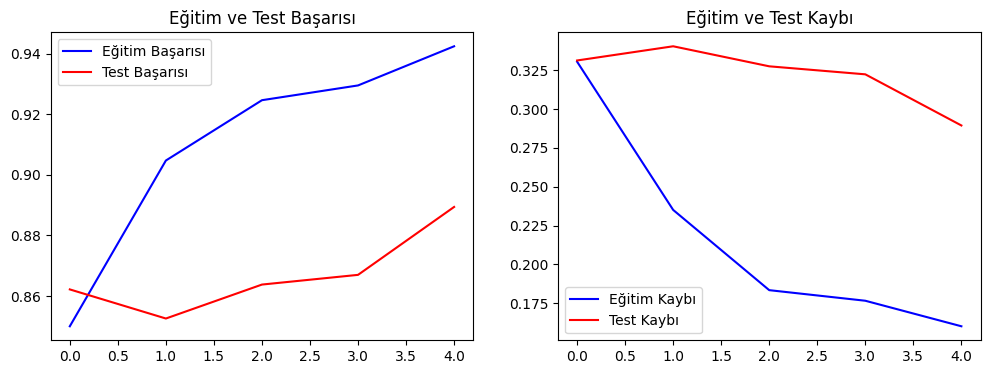

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 4))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Eğitim Başarısı')
plt.plot(epochs, val_acc, 'r', label='Test Başarısı')
plt.title('Eğitim ve Test Başarısı')
plt.legend()

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Eğitim Kaybı')
plt.plot(epochs, val_loss, 'r', label='Test Kaybı')
plt.title('Eğitim ve Test Kaybı')
plt.legend()

plt.savefig('basari_grafikleri.png') # Otomatik kaydeder
plt.show()

In [20]:
import gradio as gr
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf

# Hata almamak için modeli temizleyip tekrar yüklüyoruz
tf.keras.backend.clear_session()

from tensorflow.keras.models import load_model
# Model dosyanın adı neyse onu tam yazdığından emin ol
# Eğer 'pneumonia_model.h5' ise onu, 'pneumonia_detection_model.h5' ise onu yaz.
# Genelde son kaydettiğimiz isim: 'pneumonia_detection_model.h5' idi.
model = load_model('pneumonia_detection_model.h5')

def predict_image(img):
    # DÜZELTME BURADA: Model 224x224 istiyor, 150 yapınca kızıyor.
    img = img.resize((224, 224))

    # Resmi diziye çevir
    img_array = np.array(img)

    # Boyut ekle (Batch dimension)
    img_array = np.expand_dims(img_array, axis=0)

    # ÖNCEKİ DÜZELTME: Veri tipini float32 yapıp 255'e bölüyoruz
    img_array = img_array.astype('float32') / 255.0

    # Tahmin
    prediction = model.predict(img_array)

    # Sonuç
    confidence_pneumonia = float(prediction[0][0])
    confidence_normal = 1.0 - confidence_pneumonia

    return {"Zatürre (Pneumonia)": confidence_pneumonia, "Normal": confidence_normal}

# Arayüz
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil", label="Röntgen Yükle"),
    outputs=gr.Label(num_top_classes=2, label="Analiz Sonucu"),
    title="Zatürre Tespit Sistemi (Dr. AI)",
    description="Lütfen akciğer röntgenini yükleyin. (Model: VGG16 - 224x224)"
)

interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d8d7598454bb139ec5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d8d7598454bb139ec5.gradio.live
